In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
import matplotlib.pyplot as plt

In [2]:
def plotFunction(x, y, xtitle, ytitle, title):
    plt.plot(x, y, '-r', label="Loss")
    plt.xlabel(ytitle)
    plt.ylabel(xtitle)
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def addFillers(word, required_length):
        filler_length_to_add = required_length - len(word)
#         print(filler_length_to_add)
        filler = "\n" * filler_length_to_add
#         print(word)
        word += filler
#         print("with filler", word)
        return word

In [4]:
# Add the path of the file name to train here
filepath = '../input/names-dataset/names.txt'
file1 = open(filepath)
names = file1.readlines()
preprocessed_names = []
for i in range(len(names)):
    if len(names[i]) <= 11:
        lower_cased_names = names[i].lower()
        preprocessed_names.append(addFillers(lower_cased_names, 11))
#      print("i", i, len(preprocessed_names[i]), preprocessed_names[i])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alphabet_encoding = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12,
                    'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24,
                    'z': 25, '\n': 26}
chars = string.ascii_lowercase + '\n'
char_to_id = {c:i for i, c in enumerate(chars)}
id_to_char = {v:k for k, v in char_to_id.items()}
# print(len(preprocessed_names))

In [5]:
len(preprocessed_names)

31116

In [6]:
class NameDataset(torch.utils.data.Dataset):
    alphabet_encoding = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12,
                    'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24,
                    'z': 25, '\n': 26}
    def __init__(self, names, max_length):
        self.names = names
        self.max_length = max_length
    def __len__(self):
        return len(self.names)
    def __getitem__(self, index):
        name = self.names[index]
        expected_output = self.names[index][1:] + '\n'
        encoded_name = self.oneHotEncoding(name)
#         print(encoded_name,encoded_name.size())
        encoded_output = [self.alphabet_encoding[word] for index, word in enumerate(expected_output)]
        encoded_output = torch.tensor(encoded_output)
        convert_target = torch.tensor(encoded_output)
#         convert_data_to_long = encoded_name.type(torch.LongTensor)
        return encoded_name, convert_target
    def oneHotEncoding(self, word_to_convert):
        letter_indexes = [self.alphabet_encoding[char] for char in word_to_convert]
#         print('word', letter_indexes)
        one_hot_encoded_string = F.one_hot(torch.tensor(letter_indexes), num_classes = 27)
        return one_hot_encoded_string

In [7]:
input_size = 27
hidden_size = 27
output_size = 27
number_of_layers = 1
train_batch_size = 2593
number_of_chars = 11

In [8]:
nameDataset = NameDataset(preprocessed_names, number_of_chars)
dataLoader = torch.utils.data.DataLoader(nameDataset, train_batch_size, shuffle=True)
names, output = next(iter(dataLoader))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [9]:
class NameDataset(torch.utils.data.Dataset):
    alphabet_encoding = {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12,
                    'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24,
                    'z': 25, '\n': 26}
    def __init__(self, names, max_length):
        self.names = names
        self.max_length = max_length
    def __len__(self):
        return len(self.names)
    def __getitem__(self, index):
        name = self.names[index]
        expected_output = self.names[index][1:] + '\n'
        encoded_name = self.oneHotEncoding(name)
        encoded_output = [self.alphabet_encoding[word] for index, word in enumerate(expected_output)]
        encoded_output = torch.tensor(encoded_output)
        convert_target_to_long = encoded_output.type(torch.LongTensor)
        convert_data_to_long = encoded_name.type(torch.LongTensor)
        return convert_data_to_long, convert_target_to_long
    def oneHotEncoding(self, word_to_convert):
        letter_indexes = [self.alphabet_encoding[char] for char in word_to_convert]
#         print('word', letter_indexes)
        one_hot_encoded_string = F.one_hot(torch.tensor(letter_indexes), num_classes = 27)
        return one_hot_encoded_string

In [10]:
class NameModel(nn.Module):
    def __init__(self, input_size, hidden_size, number_of_layers, output_size, number_of_chars, batch_size):
        super(NameModel, self).__init__()
        self.number_of_chars = number_of_chars
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.number_of_layers = number_of_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=number_of_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)
    def forward(self, X, states):
        h, c = states
        out, (h, c) = self.lstm(X, (h, c))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out, (h, c)
    def initStateArguments(self):
        h = torch.zeros((self.number_of_layers, self.batch_size, self.hidden_size))
        c = torch.zeros((self.number_of_layers, self.batch_size, self.hidden_size))
        return h, c

In [11]:
def train(model, device, train_data, optimizer, scheduler, lossFn):
    number_of_epochs = 500
    model.train()
    epoch_loss_array = []
    epoch_loss = 0
    iteration = []
#     torch.autograd.set_detect_anomaly(True)
    for i, epoch in enumerate(range(number_of_epochs)):
        h, c = model.initStateArguments()
        h = h.to(device)
        c = c.to(device)
        epoch_loss = 0
        for idx, (x, y) in enumerate(train_data):
            x = x.float().to(device)
            y = y.float().to(device)
            # optimizer
#             if (len(x) != len(y)):
#                 print(idx)
#                 print('len x', len(x), 'len y', len(y))
#                 print('x = ', x, 'y = ', y)
            optimizer.zero_grad()
            predicted_output, (h, c) = model(x, (h, c))
            predicted_output = predicted_output.transpose(1, 2)
#             print(predicted_output.size(), y.size())
            long_type_y = y.long()
            loss = lossFn(predicted_output, long_type_y)
            
            h = h.detach()
            c = c.detach()
            
            loss.backward(retain_graph=True)
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_data)
        epoch_loss_array.append(epoch_loss)
        if (i % 10 == 0):
            print(f"epoch {epoch} loss: {epoch_loss}")
        iteration.append(i)
    return epoch_loss_array, iteration

In [12]:
model = NameModel(input_size, hidden_size, number_of_layers, output_size, number_of_chars, train_batch_size)
model = model.to(device)
# loss fn
lossFn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.03)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 200, gamma = 0.90)

loss, epoch = train(model, device, dataLoader, optimizer, scheduler, lossFn)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0 loss: 2.3353449205557504
epoch 10 loss: 1.2328953544298809
epoch 20 loss: 1.1467199126879375
epoch 30 loss: 1.1094255447387695
epoch 40 loss: 1.0889639457066853
epoch 50 loss: 1.0775817533334096
epoch 60 loss: 1.0708793501059215
epoch 70 loss: 1.06308717528979
epoch 80 loss: 1.0580889383951824
epoch 90 loss: 1.0552080571651459
epoch 100 loss: 1.0500761369864147
epoch 110 loss: 1.046540488799413
epoch 120 loss: 1.0439485410849254
epoch 130 loss: 1.0430824061234791
epoch 140 loss: 1.0403009255727131
epoch 150 loss: 1.0383646190166473
epoch 160 loss: 1.036787708600362
epoch 170 loss: 1.0353500346342723
epoch 180 loss: 1.0345604320367177
epoch 190 loss: 1.0332466562589009
epoch 200 loss: 1.0326174994309743
epoch 210 loss: 1.0312343041102092
epoch 220 loss: 1.0298019548257191
epoch 230 loss: 1.0296727418899536
epoch 240 loss: 1.0284009476502736
epoch 250 loss: 1.0278725226720173
epoch 260 loss: 1.0275388062000275
epoch 270 loss: 1.02654168009758
epoch 280 loss: 1.025834898153941
epo

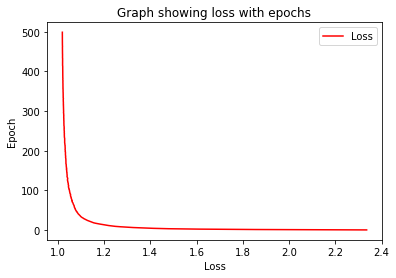

In [13]:
plotFunction(loss, epoch, 'Epoch', 'Loss', 'Graph showing loss with epochs')

In [14]:
torch.save(model.state_dict(), './modelLSTM2.pth')

In [15]:
torch.save(model, './modelLSTM2.pt')